In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as la
import os
import gmsh
import pygmsh
import meshio
from dolfin import *
# Optimization options for the dolfin form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

%matplotlib widget

Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

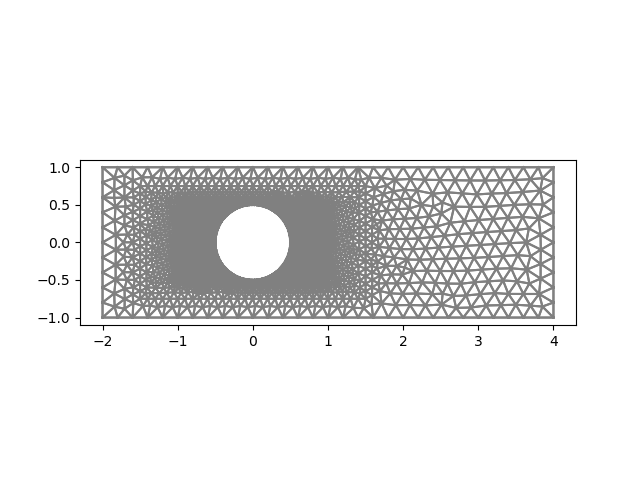

In [3]:
with pygmsh.geo.Geometry() as geom:
    # Cylinder
    r = 0.5  # radius
    rc = r/20  # resolution (=dx)
    cylinder_center = geom.add_point([0, 0, 0], rc)
    p2 = geom.add_point([r, 0, 0], rc)   # the third point coordinate is the z value: always zero in this 2D example.
    p3 = geom.add_point([0, r, 0], rc)
    p4 = geom.add_point([-r, 0, 0], rc)
    p5 = geom.add_point([0, -r, 0], rc)
    
    circle1 = geom.add_circle_arc(p2, cylinder_center, p3)
    circle2 = geom.add_circle_arc(p3, cylinder_center, p4)
    circle3 = geom.add_circle_arc(p4, cylinder_center, p5)
    circle4 = geom.add_circle_arc(p5, cylinder_center, p2)
    
    # First (inner) rectangle
    l1up = -2*r
    l1down = 2*r
    h1 = r*1.1
    r1 = rc*2
    
    p11 = geom.add_point([l1up, h1, 0], r1)
    p12 = geom.add_point([l1down, h1, 0], r1)
    p13 = geom.add_point([l1down, -h1, 0], r1)
    p14 = geom.add_point([l1up, -h1, 0], r1)
    
    line11 = geom.add_line(p11, p12)
    line12 = geom.add_line(p12, p13)
    line13 = geom.add_line(p13, p14)
    line14 = geom.add_line(p14, p11)
    
    # Second rectangle
    l2up = -3*r
    l2down = 3*r
    h2 = 1.5*r
    r2 = 4*rc
    
    p21 = geom.add_point([l2up, h2, 0], r2)
    p22 = geom.add_point([l2down, h2, 0], r2)
    p23 = geom.add_point([l2down, -h2, 0], r2)
    p24 = geom.add_point([l2up, -h2, 0], r2)
    
    line21 = geom.add_line(p21, p22)
    line22 = geom.add_line(p22, p23)
    line23 = geom.add_line(p23, p24)
    line24 = geom.add_line(p24, p21)
    
    # Outer rectangle (box boundary)
    l3down = 8*r
    l3up = -4*r
    h3 = 2*r#20.0 * r
    r3 = 8*rc#40 * rc
    
    p31 = geom.add_point([l3up, h3, 0], r3)
    p31_ = geom.add_point([l3up, 0.9*h3, 0], r3)
    p32 = geom.add_point([l3down, h3, 0], r3)
    p33 = geom.add_point([l3down, -h3, 0], r3)
    p34 = geom.add_point([l3up, -h3, 0], r3)
    
    line31 = geom.add_line(p31, p32)
    line31_ = geom.add_line(p31_, p32)
    line32 = geom.add_line(p32, p33)
    line33 = geom.add_line(p33, p34)
    line34 = geom.add_line(p34, p31)
    
    # Line loops and surfaces
    loop1 = geom.add_curve_loop([circle1, circle2, circle3, circle4])
    loop2 = geom.add_curve_loop([line11, line12, line13, line14])
    loop3 = geom.add_curve_loop([line21, line22, line23, line24])
    loop4 = geom.add_curve_loop([line31, line32, line33, line34])
    
    surface1 = geom.add_plane_surface(loop2, [loop1])  # inner rectangle minus the cylinder
    surface2 = geom.add_plane_surface(loop3, [loop2])  # second rectangle minus inner rectangle
    surface3 = geom.add_plane_surface(loop4, [loop3])           # outer rectangle minus second rectangle
    
    # Define physical groups
    geom.add_physical([surface1, surface2, surface3], label="Domain")
    geom.add_physical([circle1, circle2, circle3, circle4], label="Cylinder")
    geom.add_physical([line31_], label="Inlet")
    geom.add_physical([line31, line34], label="Lateral")
    geom.add_physical([line32, line22, line33], label="Outlet")
    
    # Generate the mesh
    mesh = geom.generate_mesh()
    
# Save the mesh to a file, this can be opened with gmsh if needed
mesh.write("Mesh/cylinder.msh", file_format="gmsh22")

# read mesh with meshio for conversion to xdmf
mesh_from_file = meshio.read("Mesh/cylinder.msh")
# extract cells and physical data from the mesh
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(
        points=points, cells={cell_type: cells}, cell_data={"name_to_read": [cell_data]}
    )
    return out_mesh
    
# write xdmf files
triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("Mesh/cylinder.xdmf", triangle_mesh)
#   unused:
#line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
#meshio.write("Mesh/facet_cylinder.xdmf", line_mesh)

# read xdmf file
mesh = Mesh()
with XDMFFile("Mesh/cylinder.xdmf") as infile:
    infile.read(mesh)

plot(mesh)
plt.show()

In [4]:
mesh = Mesh()
with XDMFFile("Mesh/cylinder.xdmf") as infile:
    infile.read(mesh)

V=VectorElement("Lagrange",mesh.ufl_cell(),2) # on each mesh element: Lagrange polynomials of order 2 (for velocity)
Q=FiniteElement("Lagrange",mesh.ufl_cell(),1) # on each mesh element: Lagrange polynomials of order 1 (for pressure)
TH = MixedElement([V, Q])
X=FunctionSpace(mesh,TH)

In [5]:
# functions that decide whether any mesh point x lies on a boundary, and on which:
def cylinder(x, on_boundary): 
    return (x[0]**2+x[1]**2)**0.5 < r*1.000001 and on_boundary 
def inlet(x, on_boundary):       
    return x[0] < (l3up*0.9999) and on_boundary 
def outlet(x, on_boundary):         
    return x[0] > (l3down * 0.9999) and on_boundary 
def upperandlower(x, on_boundary):
    return np.abs(x[1]) > h3*0.9999 and on_boundary 
# conditions to be applied on each of these boundaries:\


u_in = 1
bc_cyl=DirichletBC(X.sub(0), (0,0), cylinder)   # both velocity components are zero on the solid
bc_inflow = DirichletBC(X.sub(0), (1,0), inlet) # u=1 and v=0 at the inlet
bc_upperandlower=DirichletBC(X.sub(0).sub(1), 0, upperandlower) # slip condition v=0 at side boundaries
bcs = [bc_cyl,bc_inflow,bc_upperandlower]

In [6]:
# functions that decide whether any mesh point x lies on a boundary, and on which:
def cylinder(x, on_boundary): 
    return (x[0]**2+x[1]**2)**0.5 < r*1.000001 and on_boundary 
def inlet(x, on_boundary):       
    return x[0] < (l3up*0.9999) and on_boundary 
def outlet(x, on_boundary):         
    return x[0] > (l3down * 0.9999) and on_boundary 
def upperandlower(x, on_boundary):
    return np.abs(x[1]) > h3*0.9999 and on_boundary 
# conditions to be applied on each of these boundaries:\


u_in = 1
bc_cyl=DirichletBC(X.sub(0), (0,0), cylinder)   # both velocity components are zero on the solid
bc_inflow = DirichletBC(X.sub(0), (1,0), inlet) # u=1 and v=0 at the inlet
bc_upperandlower=DirichletBC(X.sub(0).sub(1), 0, upperandlower) # slip condition v=0 at side boundaries
bcs = [bc_cyl,bc_inflow,bc_upperandlower]

In [7]:
up = Function(X) # function object representing the solution
up_init = Function(X)
dup = TrialFunction(X)
vp = TestFunction(X) 

u  = as_vector((up[0],up[1]))   
p  = up[2]   
v  = as_vector((vp[0],vp[1]))   
q  = vp[2]

Re = 0.001#30.

# full eq 
#F   =  inner(grad(u)*u, v)*dx  + 1/Re*inner(grad(u), grad(v))*dx - div(v)*p*dx + q*div(u)*dx
# no convection
F   =   1/Re*inner(grad(u), grad(v))*dx - div(v)*p*dx + q*div(u)*dx
#dF  = derivative(F, up, dup) 

In [ ]:
solve(F == 0,up,bcs=bcs)
c=plot(u[0], cmap='coolwarm') # you can add ",vmin=-1, vmax=1" to set the colour limits
plt.show()
plt.colorbar(c)
# write results to file
respath = "./Results/Re"+str(int(Re))+"/"
File(respath+"baseflow.xml") << up.vector()

# write vtk files for visualisation with Paraview
u,p = up.split()
u.rename("v","velocity");  p.rename("p","pressure");
File(respath+"baseflow_u.pvd") << u
File(respath+"baseflow_p.pvd") << p

In [ ]:

# Define the gradient of the velocity field
velocity_gradient = grad(u)  # u is the velocity field obtained after solving

# Project the gradient onto a suitable function space for visualization
W = TensorFunctionSpace(mesh, "CG", 1)  # TensorFunctionSpace for 2D/3D tensors
grad_u = project(velocity_gradient, W)

# Save gradient field to file for visualization in Paraview
grad_u.rename("grad_u", "velocity_gradient")
File(respath + "velocity_gradient.pvd") << grad_u

# Plot one component of the gradient, e.g., ∂u/∂x
plt.figure()
c = plot(grad_u[1, 0], cmap='coolwarm')  # Change indices for other components
plt.colorbar(c)
plt.title(r"Gradient Component $\partial u_y / \partial x$")
plt.show()